# U-Net training example notebook

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os #a library to interact with the file system
import cv2 #a library to access the images
from PIL import Image

import rasterio #a library that facilitates working with raster data
from rasterio.enums import Resampling
from rasterio.plot import reshape_as_image, show
import rasterio.mask
from rasterio.features import rasterize
from rasterio.plot import show
from rasterio import features
from rasterio.features import shapes
from sklearn.preprocessing import MinMaxScaler
from skimage.io import imshow
from patchify import patchify, unpatchify #to patchifly large images into smaller patches
from matplotlib import pyplot as plt
import random
import tensorflow as tf

import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Reshape
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda, SpatialDropout2D
from keras import backend as K

import segmentation_models as sm
import glob
import albumentations as A

import shapely
from shapely.geometry import Point, Polygon
from shapely.ops import transform
from shapely.geometry import Polygon, MultiPolygon

import geopandas as gpd
import folium
import pyproj
import json
import shutil
# from gradient_accumulator import GradientAccumulateModel
from keras.models import load_model
from datetime import datetime
import matplotlib.ticker as ticker
from skimage import io, exposure, data
time = datetime.now().strftime("%Y%m%d")

Segmentation Models: using `keras` framework.


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Data Preparation

In [3]:
def load_geotiff_image(file_path):
    """
    A function that uses the rasterio library to read a GeoTIFF image and convert it into a numpy array
    """
    scale_factor = 0.5
    
    with rasterio.open(file_path) as dataset:

    # resample data to target shape
        data = dataset.read(out_shape=(dataset.count, int(dataset.height * scale_factor), int(dataset.width * scale_factor)), resampling=Resampling.bilinear)

    # scale image transform
        transform = dataset.transform * dataset.transform.scale((dataset.width / data.shape[-1]),(dataset.height / data.shape[-2]))
    
    #rearrage the order of the image channel from first to last
    image = np.moveaxis(data, 0, -1)
    return image

def normalise(input_image):
    n_image = (input_image - input_image.min()) / (input_image.max()- input_image.min())
    return n_image

In [4]:
def load_geotiff_imageL(file_path):
    """
    A function that uses the rasterio library to read a GeoTIFF image and convert it into a numpy array
    """
    
    with rasterio.open(file_path) as dataset:
        
        data = dataset.read()

    #rearrage the order of the image channel from first to last
    image = np.moveaxis(data, 0, -1)
    return image

In [5]:
directory_path = '/kaggle/input/oilspill-dataset-utm'
dataset = 'oilspill_dataset'

image_dataset = []
for idx in range(1,55):
    image = load_geotiff_image(f'{directory_path}/{dataset}/train/images/image_{idx}.tif')
    image = np.array(image)
    image[np.isnan(image)] = 0
    masked_array = np.ma.masked_greater(image, -1.0)
    image[(image >= -1.0)] = np.ma.median(masked_array)
#     percentiles = np.percentile(image, (0.1, 99.9))
#     image = exposure.rescale_intensity(image, in_range=tuple(percentiles))
    image = normalise(image)
    wind = load_geotiff_image(f'{directory_path}/{dataset}/train/wind/wind_{idx}.tif')
    wind = normalise(wind)
    #rasterio will read the wind images upside down so we have to flip the vetrical axis
    wind = np.flip(wind[:], axis=0)
    # Stack the two bands together
    input_image_2ch = np.dstack((image, wind))
    image_dataset.append(input_image_2ch)

mask_dataset = []
for idx in range(1,55):
    mask = load_geotiff_image(f'{directory_path}/{dataset}/train/masks/mask_{idx}.tif')
    mask_dataset.append(mask)

val_image_dataset = []
for idx in range(1,14):
    val_image = load_geotiff_image(f'{directory_path}/{dataset}/validation/images/image_{idx}.tif')
    val_image = np.array(val_image)
    val_image[np.isnan(val_image)] = 0
    val_masked_array = np.ma.masked_greater(val_image, -1.0)
    val_image[(val_image >= -1.0)] = np.ma.median(val_masked_array)
#     percentiles = np.percentile(val_image, (0.1, 99.9))
#     val_image = exposure.rescale_intensity(val_image, in_range=tuple(percentiles))
    val_image = normalise(val_image)
    val_wind = load_geotiff_image(f'{directory_path}/{dataset}/validation/wind/wind_{idx}.tif')
    val_wind = normalise(val_wind)
    #rasterio will read the wind images upside down so we have to flip the vetrical axis
    val_wind = np.flip(val_wind[:], axis=0)
    # Stack the two bands together
    val_input_image_2ch = np.dstack((val_image, val_wind))   
    val_image_dataset.append(val_input_image_2ch)
    
val_mask_dataset = []
for idx in range(1,14):
    val_mask = load_geotiff_image(f'{directory_path}/{dataset}/validation/masks/mask_{idx}.tif')
    val_mask_dataset.append(val_mask)

In [6]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
val_image_dataset = np.array(val_image_dataset)
val_mask_dataset = np.array(val_mask_dataset)

print(image_dataset.shape)
print(mask_dataset.shape)
print(val_image_dataset.shape)
print(val_mask_dataset.shape)

image_height = image_dataset.shape[1]
image_width = image_dataset.shape[2]
image_channels = image_dataset.shape[3]
total_classes = mask_dataset.shape[3]

(54, 512, 512, 2)
(54, 512, 512, 1)
(13, 512, 512, 2)
(13, 512, 512, 1)


# Applying data augmentation

## Define a function to visualize images and mask

In [7]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 16
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(3, 1, figsize=(12, 12))

        ax[0].imshow(image[:, :, 0], cmap='gray')
        ax[1].imshow(image[:, :, 1], cmap='gray')
        ax[2].imshow(mask, cmap='gray')
    
    else:
        f, ax = plt.subplots(3, 2, figsize=(12, 12))

        ax[0, 0].imshow(original_image[:, :, 0], cmap='gray')
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_image[:, :, 1], cmap='gray')
        ax[1, 0].set_title('Original wind', fontsize=fontsize)
        
        ax[2, 0].imshow(original_mask, cmap='gray')
        ax[2, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image[:, :, 0], cmap='gray')
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(image[:, :, 1], cmap='gray')
        ax[1, 1].set_title('Transformed wind', fontsize=fontsize)
        
        ax[2, 1].imshow(mask, cmap='gray')
        ax[2, 1].set_title('Transformed mask', fontsize=fontsize)

## Horizontal Flip

In [8]:
h_flipped_image_dataset = []
h_flipped_mask_dataset = []

for x in range(len(image_dataset)):
    aug = A.HorizontalFlip(p=1)
    augmented = aug(image=image_dataset[x], mask=mask_dataset[x])
    image_h_flipped = augmented['image']
    mask_h_flipped = augmented['mask']
    h_flipped_image_dataset.append(image_h_flipped)
    h_flipped_mask_dataset.append(mask_h_flipped)

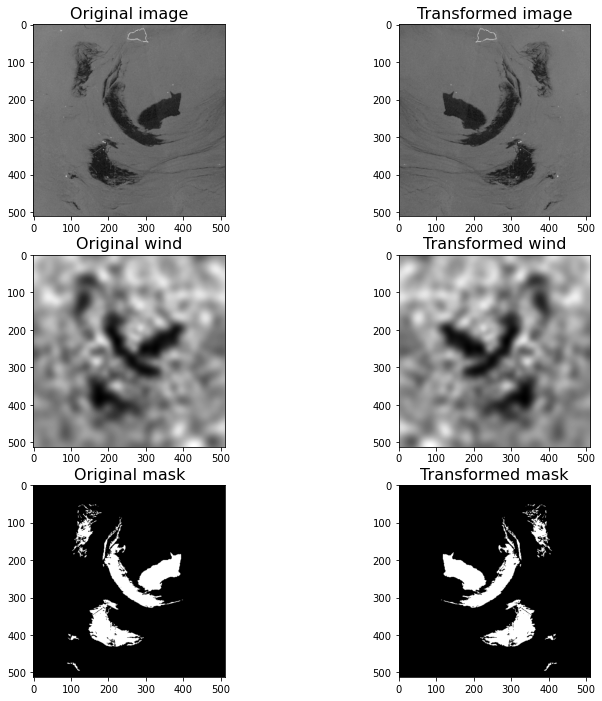

In [9]:
visualize(h_flipped_image_dataset[5], h_flipped_mask_dataset[5], original_image=image_dataset[5], original_mask=mask_dataset[5])

## Vertical Flip

In [10]:
v_flipped_image_dataset = []
v_flipped_mask_dataset = []

for x in range(len(image_dataset)):
    aug = A.VerticalFlip(p=1)
    augmented = aug(image=image_dataset[x], mask=mask_dataset[x])
    image_v_flipped = augmented['image']
    mask_v_flipped = augmented['mask']
    v_flipped_image_dataset.append(image_v_flipped)
    v_flipped_mask_dataset.append(mask_v_flipped)

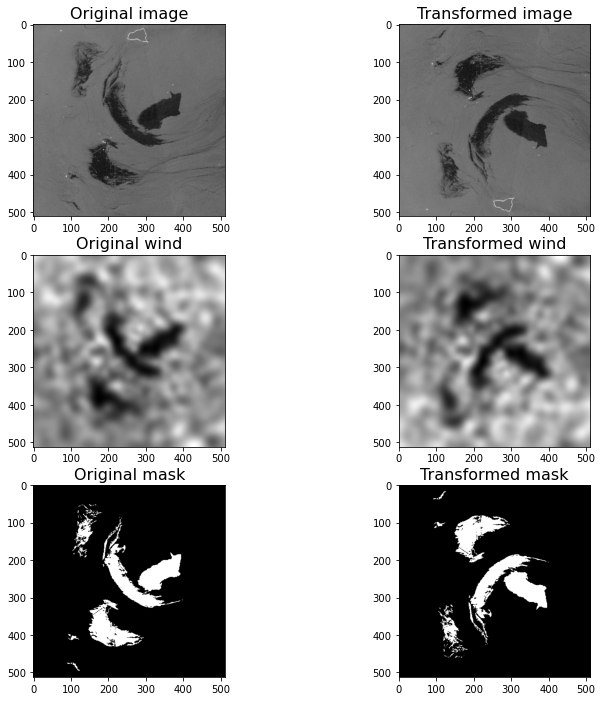

In [11]:
visualize(v_flipped_image_dataset[5], v_flipped_mask_dataset[5], original_image=image_dataset[5], original_mask=mask_dataset[5])

## RandomRotate90 (rotates by 90 degrees)

In [12]:
rot90_image_dataset = []
rot90_mask_dataset = []

for x in range(len(image_dataset)):
    aug = A.RandomRotate90(p=1)
    augmented = aug(image=image_dataset[x], mask=mask_dataset[x])
    image_rot90 = augmented['image']
    mask_rot90 = augmented['mask']
    rot90_image_dataset.append(image_rot90)
    rot90_mask_dataset.append(mask_rot90)

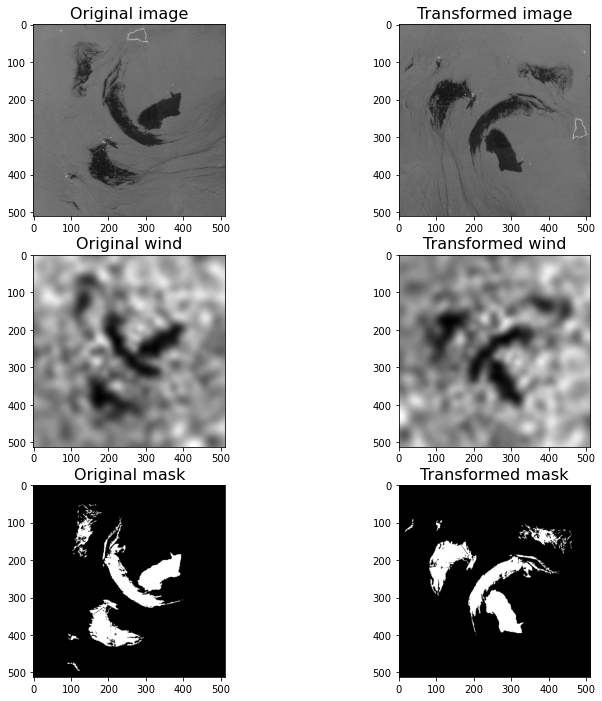

In [13]:
visualize(rot90_image_dataset[5], rot90_mask_dataset[5], original_image=image_dataset[5], original_mask=mask_dataset[5])

## Transpose (switch X and Y axis)

In [14]:
transposed_image_dataset = []
transposed_mask_dataset = []

for x in range(len(image_dataset)):
    aug = A.Transpose(p=1)
    augmented = aug(image=image_dataset[x], mask=mask_dataset[x])
    image_transposed = augmented['image']
    mask_transposed = augmented['mask']
    transposed_image_dataset.append(image_transposed)
    transposed_mask_dataset.append(mask_transposed)

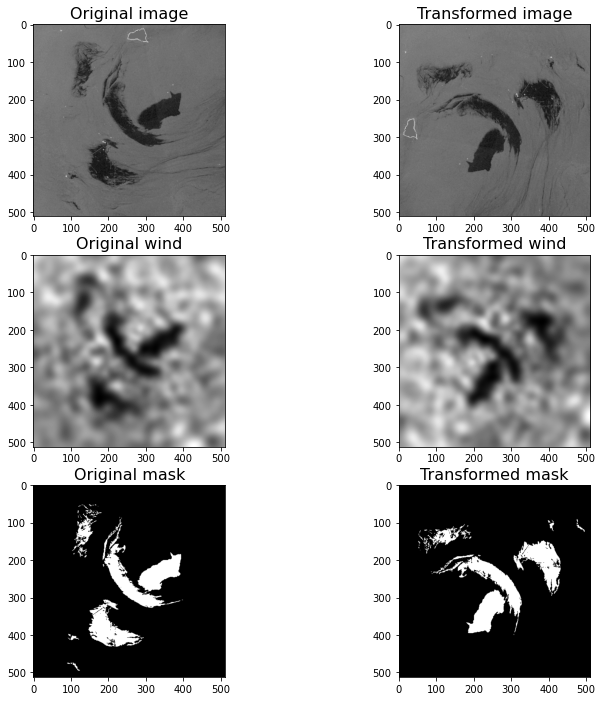

In [15]:
visualize(transposed_image_dataset[5], transposed_mask_dataset[5], original_image=image_dataset[5], original_mask=mask_dataset[5])

In [18]:
augmented_image_dataset = np.concatenate((image_dataset,
                                          h_flipped_image_dataset,
                                          v_flipped_image_dataset,
                                          rot90_image_dataset,
                                          transposed_image_dataset), axis=0)

augmented_mask_dataset = np.concatenate((mask_dataset,
                                         h_flipped_mask_dataset,
                                         v_flipped_mask_dataset,
                                         rot90_mask_dataset,
                                         transposed_mask_dataset), axis=0)

In [19]:
image_dataset_1ch = image_dataset[:,:,:,0]
val_image_dataset_1ch = val_image_dataset[:,:,:,0]
image_dataset_1ch = np.expand_dims(image_dataset_1ch, axis=-1)
val_image_dataset_1ch = np.expand_dims(val_image_dataset_1ch, axis=-1)
image_channels_1ch = image_dataset_1ch.shape[3]

# Converting the input to tensor
image_dataset_tf = tf.convert_to_tensor(image_dataset)
val_image_dataset_tf = tf.convert_to_tensor(val_image_dataset)
image_dataset_1ch_tf = tf.convert_to_tensor(image_dataset_1ch)
val_image_dataset_1ch_tf =  tf.convert_to_tensor(val_image_dataset_1ch)
mask_dataset_tf = tf.cast(mask_dataset, dtype=tf.float32)
val_mask_dataset_tf = tf.cast(val_mask_dataset, dtype=tf.float32)

augmented_image_dataset_1ch = augmented_image_dataset[:,:,:,0]
val_image_dataset_1ch = val_image_dataset[:,:,:,0]

augmented_image_dataset_1ch = np.expand_dims(augmented_image_dataset_1ch, axis=-1)
val_image_dataset_1ch = np.expand_dims(val_image_dataset_1ch, axis=-1)

image_channels_1ch = image_dataset_1ch.shape[3]

# Converting the input to tensor
augmented_image_dataset_1ch_tf = tf.convert_to_tensor(augmented_image_dataset_1ch)
augmented_mask_dataset_tf = tf.cast(augmented_mask_dataset, dtype=tf.float32)

# Converting the input to tensor
augmented_image_dataset_tf = tf.convert_to_tensor(augmented_image_dataset)
augmented_mask_dataset_tf = tf.cast(augmented_mask_dataset, dtype=tf.float32)

# Training the model without augmented data or wind speed channel

In [20]:
#build the model
inputs = Input((image_height, image_width, image_channels_1ch))

#contraction path
c1 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = SpatialDropout2D(0.1)(c1)
c1 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = SpatialDropout2D(0.1)(c2)
c2 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = SpatialDropout2D(0.2)(c3)
c3 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2,2))(c3)

c4 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = SpatialDropout2D(0.2)(c4)
c4 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2,2))(c4)

c5 = Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = SpatialDropout2D(0.3)(c5)
c5 = Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#expansive path
u6 = Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = SpatialDropout2D(0.2)(c6)
c6 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = SpatialDropout2D(0.2)(c7)
c7 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = SpatialDropout2D(0.1)(c8)
c8 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = SpatialDropout2D(0.1)(c9)
c9 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)

In [21]:
model1_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/unet_200epc_no_aug_best_'+time+'.h5',
    monitor='val_iou_score',
    mode='max',
    save_best_only=True)
csv_logger1 = tf.keras.callbacks.CSVLogger('unetmodel_200epc_no_aug_training_'+time+'.csv')

In [22]:
model1 = Model(inputs=[inputs], outputs=[outputs])

model1.compile(optimizer='adam', loss=sm.losses.bce_dice_loss, metrics=sm.metrics.iou_score)

# model1.summary()

history1 = model1.fit(image_dataset_1ch_tf, mask_dataset_tf,
                    validation_data=(val_image_dataset_1ch_tf,val_mask_dataset_tf),
                    batch_size=4,
                    verbose=1,
                    epochs=200,
                    callbacks=[model1_checkpoint_callback,csv_logger1]
                     )

Epoch 1/200
14/14 [==============================] - 29s 971ms/step - loss: 1.2567 - iou_score: 0.0515 - val_loss: 0.9711 - val_iou_score: 0.0575
Epoch 2/200
14/14 [==============================] - 6s 433ms/step - loss: 0.9839 - iou_score: 0.0726 - val_loss: 0.9175 - val_iou_score: 0.0835
Epoch 3/200
14/14 [==============================] - 6s 433ms/step - loss: 0.9457 - iou_score: 0.0952 - val_loss: 0.8064 - val_iou_score: 0.1386
Epoch 4/200
14/14 [==============================] - 6s 432ms/step - loss: 0.8666 - iou_score: 0.1406 - val_loss: 0.5719 - val_iou_score: 0.3281
Epoch 5/200
14/14 [==============================] - 6s 433ms/step - loss: 0.8099 - iou_score: 0.2641 - val_loss: 0.4809 - val_iou_score: 0.4358
Epoch 6/200
14/14 [==============================] - 6s 449ms/step - loss: 0.6658 - iou_score: 0.3137 - val_loss: 0.4519 - val_iou_score: 0.5311
Epoch 7/200
14/14 [==============================] - 6s 432ms/step - loss: 0.6391 - iou_score: 0.3574 - val_loss: 0.3282 - val_io

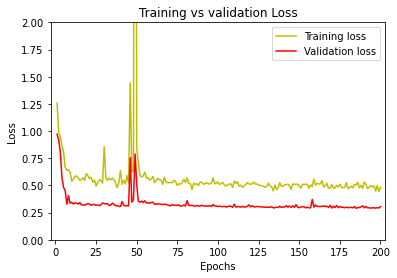

In [23]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'y', label="Training loss")
plt.plot(epochs, val_loss, 'r', label="Validation loss")
plt.title("Training vs validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xlim(-3, 203)
plt.ylim(0.0,2.0)
plt.legend()
plt.savefig('loss_graph_unet_no_aug_200epc_4bch_'+time+'.png', dpi=300, format='png')
plt.show()

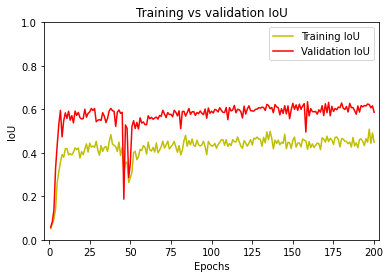

In [24]:
jc = history1.history['iou_score']
val_jc= history1.history['val_iou_score']
epochs = range(1, len(loss)+1)

plt.plot(epochs, jc, 'y', label="Training IoU")
plt.plot(epochs, val_jc, 'r', label="Validation IoU")
plt.title("Training vs validation IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.xlim(-3, 203)
plt.ylim(0.0,1)
plt.legend()
plt.savefig('metric_graph_unet_no_aug_200epc_4bch_'+time+'.png', dpi=300, format='png')
plt.show()

1/1 [==============================] - 0s 333ms/step - loss: 0.1532 - iou_score: 0.8040


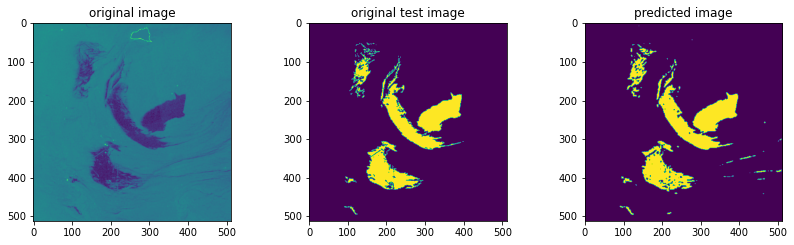

In [25]:
# test_image_number = 0
test_image_number = random.randint(0, len(image_dataset)-1)

test_image = image_dataset_1ch_tf[test_image_number]
ground_truth_image = mask_dataset_tf[test_image_number]

test_image_input = np.expand_dims(test_image, axis=0)
mask_image_input = np.expand_dims(ground_truth_image, axis=0)

evaluation = model1.evaluate(test_image_input, mask_image_input)

prediction = model1.predict(test_image_input)
predicted_image = (prediction > 0.5).astype(np.uint8)

plt.figure(figsize=(14,8))

plt.subplot(231)
plt.title("original image")
plt.imshow(test_image)

plt.subplot(232)
plt.title("original test image")
plt.imshow(ground_truth_image)

plt.subplot(233)
plt.title("predicted image")
plt.imshow(np.squeeze(predicted_image))
plt.show()

In [26]:
del model1
tf.keras.backend.clear_session()

# Training with data augmentation without wind speed channel

In [27]:
#build the model
inputs = Input((image_height, image_width, image_channels_1ch))

#contraction path
c1 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = SpatialDropout2D(0.1)(c1)
c1 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = SpatialDropout2D(0.1)(c2)
c2 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = SpatialDropout2D(0.2)(c3)
c3 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2,2))(c3)

c4 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = SpatialDropout2D(0.2)(c4)
c4 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2,2))(c4)

c5 = Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = SpatialDropout2D(0.3)(c5)
c5 = Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#expansive path
u6 = Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = SpatialDropout2D(0.2)(c6)
c6 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = SpatialDropout2D(0.2)(c7)
c7 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = SpatialDropout2D(0.1)(c8)
c8 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = SpatialDropout2D(0.1)(c9)
c9 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)

In [28]:
model2_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/unet_200epc_aug_best_'+time+'.h5',
    monitor='val_iou_score',
    mode='max',
    save_best_only=True)
csv_logger2 = tf.keras.callbacks.CSVLogger('unet_200epc_aug_training_'+time+'.csv')

In [29]:
model2 = Model(inputs=[inputs], outputs=[outputs])

model2.compile(optimizer='adam', loss=sm.losses.bce_dice_loss, metrics=sm.metrics.iou_score)

history2 = model2.fit(augmented_image_dataset_1ch_tf, augmented_mask_dataset_tf,
                    validation_data=(val_image_dataset_1ch_tf,val_mask_dataset_tf),
                    batch_size=6,
                    verbose=1,
                    epochs=200,
                    callbacks=[model2_checkpoint_callback,csv_logger2]  
                    )

Epoch 1/200
45/45 [==============================] - 39s 612ms/step - loss: 1.0149 - iou_score: 0.0772 - val_loss: 0.8007 - val_iou_score: 0.1565
Epoch 2/200
45/45 [==============================] - 27s 609ms/step - loss: 0.7067 - iou_score: 0.2783 - val_loss: 0.4701 - val_iou_score: 0.3730
Epoch 3/200
45/45 [==============================] - 27s 608ms/step - loss: 0.6077 - iou_score: 0.3757 - val_loss: 0.3718 - val_iou_score: 0.4509
Epoch 4/200
45/45 [==============================] - 27s 603ms/step - loss: 0.5541 - iou_score: 0.4190 - val_loss: 0.2496 - val_iou_score: 0.6017
Epoch 5/200
45/45 [==============================] - 27s 603ms/step - loss: 0.5596 - iou_score: 0.4089 - val_loss: 0.2307 - val_iou_score: 0.6331
Epoch 6/200
45/45 [==============================] - 27s 608ms/step - loss: 0.5457 - iou_score: 0.4187 - val_loss: 0.3028 - val_iou_score: 0.5299
Epoch 7/200
45/45 [==============================] - 27s 604ms/step - loss: 0.5637 - iou_score: 0.3977 - val_loss: 0.2618 - 

## Plotting training graphs

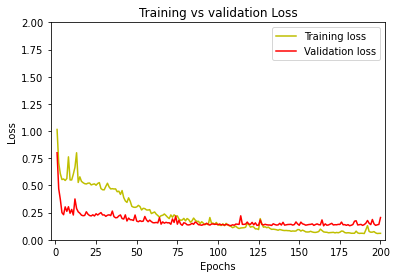

In [30]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'y', label="Training loss")
plt.plot(epochs, val_loss, 'r', label="Validation loss")
plt.title("Training vs validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xlim(-3, 203)
plt.ylim(0.0,2.0)
plt.legend()
plt.savefig('loss_graph_unet_aug_200epc_6bch_'+time+'.png', dpi=300, format='png')
plt.show()

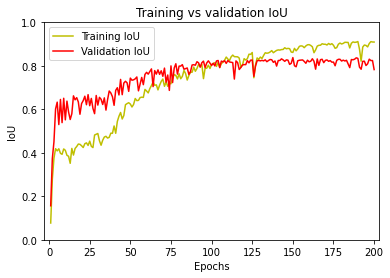

In [31]:
jc = history2.history['iou_score']
val_jc= history2.history['val_iou_score']
epochs = range(1, len(loss)+1)

plt.plot(epochs, jc, 'y', label="Training IoU")
plt.plot(epochs, val_jc, 'r', label="Validation IoU")
plt.title("Training vs validation IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.xlim(-3, 203)
plt.ylim(0.0,1)
plt.legend()
plt.savefig('metric_graph_unet_aug_200epc_6bch_'+time+'.png', dpi=300, format='png')
plt.show()

1/1 [==============================] - 0s 412ms/step - loss: 0.0503 - iou_score: 0.9097
[0.050301842391490936, 0.9097249507904053]


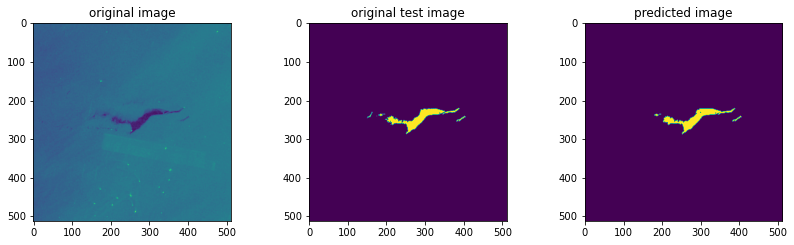

In [32]:
# test_image_number = 0
test_image_number = random.randint(0, len(augmented_image_dataset_1ch_tf)-1)

test_image = augmented_image_dataset_1ch_tf[test_image_number]
ground_truth_image = augmented_mask_dataset_tf[test_image_number]

test_image_input = np.expand_dims(test_image, axis=0)
mask_image_input = np.expand_dims(ground_truth_image, axis=0)

evaluation = model2.evaluate(test_image_input, mask_image_input)
print(evaluation)
prediction = model2.predict(test_image_input)
predicted_image = (prediction > 0.5).astype(np.uint8)

plt.figure(figsize=(14,8))

plt.subplot(231)
plt.title("original image")
plt.imshow(test_image)

plt.subplot(232)
plt.title("original test image")
plt.imshow(ground_truth_image)

plt.subplot(233)
plt.title("predicted image")
plt.imshow(np.squeeze(predicted_image))
plt.show()

In [33]:
del model2
tf.keras.backend.clear_session()

## Training with data augmentation and wind speed channel

In [34]:
#build the model
inputs = Input((image_height, image_width, image_channels))

#contraction path
c1 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = SpatialDropout2D(0.1)(c1)
c1 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = SpatialDropout2D(0.1)(c2)
c2 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = SpatialDropout2D(0.2)(c3)
c3 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2,2))(c3)

c4 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = SpatialDropout2D(0.2)(c4)
c4 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2,2))(c4)

c5 = Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = SpatialDropout2D(0.3)(c5)
c5 = Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#expansive path
u6 = Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = SpatialDropout2D(0.2)(c6)
c6 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = SpatialDropout2D(0.2)(c7)
c7 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = SpatialDropout2D(0.1)(c8)
c8 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = SpatialDropout2D(0.1)(c9)
c9 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)

In [35]:
model3_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/unet_200epc_aug_wind_best_'+time+'.h5',
    monitor='val_iou_score',
    mode='max',
    save_best_only=True)
csv_logger3 = tf.keras.callbacks.CSVLogger('unet_200epc_aug_wind_training_'+time+'.csv')

In [36]:
model3 = Model(inputs=[inputs], outputs=[outputs])

model3.compile(optimizer='adam', loss=sm.losses.bce_dice_loss, metrics=sm.metrics.iou_score)

history3 = model3.fit(augmented_image_dataset_tf, augmented_mask_dataset_tf,
                    validation_data=(val_image_dataset_tf,val_mask_dataset_tf),
                    batch_size=6,
                    verbose=1,
                    epochs=200,
                    callbacks=[model3_checkpoint_callback,csv_logger3]
                    )

Epoch 1/200
45/45 [==============================] - 29s 614ms/step - loss: 0.9968 - iou_score: 0.0810 - val_loss: 0.8972 - val_iou_score: 0.1103
Epoch 2/200
45/45 [==============================] - 27s 610ms/step - loss: 0.8524 - iou_score: 0.1592 - val_loss: 0.5294 - val_iou_score: 0.3554
Epoch 3/200
45/45 [==============================] - 27s 605ms/step - loss: 0.7679 - iou_score: 0.2902 - val_loss: 0.6347 - val_iou_score: 0.2473
Epoch 4/200
45/45 [==============================] - 27s 605ms/step - loss: 0.6909 - iou_score: 0.2941 - val_loss: 0.4065 - val_iou_score: 0.4088
Epoch 5/200
45/45 [==============================] - 27s 605ms/step - loss: 0.6453 - iou_score: 0.3325 - val_loss: 0.3424 - val_iou_score: 0.4841
Epoch 6/200
45/45 [==============================] - 27s 605ms/step - loss: 0.6390 - iou_score: 0.3418 - val_loss: 0.4037 - val_iou_score: 0.3990
Epoch 7/200
45/45 [==============================] - 27s 604ms/step - loss: 0.6003 - iou_score: 0.3693 - val_loss: 0.2955 - 

## Plotting training graphs

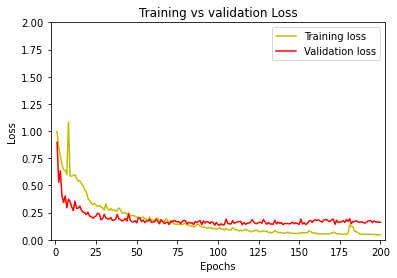

In [37]:
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'y', label="Training loss")
plt.plot(epochs, val_loss, 'r', label="Validation loss")
plt.title("Training vs validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xlim(-3, 203)
plt.ylim(0.0,2.0)
plt.legend()
plt.savefig('loss_graph_unet_aug_wind_200epc_6bch_'+time+'.png', dpi=300, format='png')
plt.show()

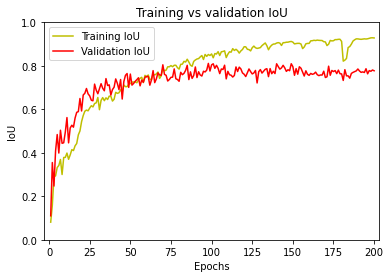

In [38]:
jc = history3.history['iou_score']
val_jc= history3.history['val_iou_score']
epochs = range(1, len(loss)+1)

plt.plot(epochs, jc, 'y', label="Training IoU")
plt.plot(epochs, val_jc, 'r', label="Validation IoU")
plt.title("Training vs validation IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.xlim(-3, 203)
plt.ylim(0.0,1)
plt.legend()
plt.savefig('metric_graph_unet_aug_wind_200epc_6bch_'+time+'.png', dpi=300, format='png')
plt.show()

1/1 [==============================] - 0s 334ms/step - loss: 0.0786 - iou_score: 0.8661


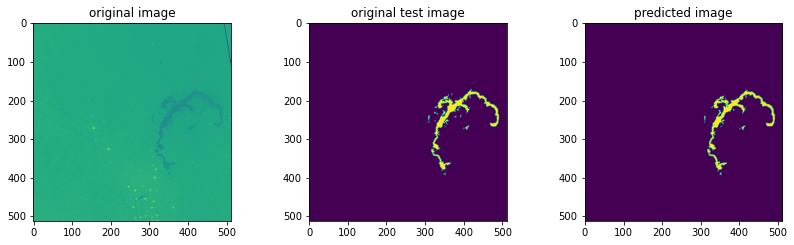

In [39]:
# test_image_number = 0
test_image_number = random.randint(0, len(augmented_image_dataset_tf)-1)

test_image = augmented_image_dataset_tf[test_image_number]
ground_truth_image = augmented_mask_dataset_tf[test_image_number]

test_image_input = np.expand_dims(test_image, axis=0)
mask_image_input = np.expand_dims(ground_truth_image, axis=0)

evaluation = model3.evaluate(test_image_input, mask_image_input)

prediction = model3.predict(test_image_input)
predicted_image = (prediction > 0.5).astype(np.uint8)

plt.figure(figsize=(14,8))

plt.subplot(231)
plt.title("original image")
plt.imshow(test_image[:, :, 0])

plt.subplot(232)
plt.title("original test image")
plt.imshow(ground_truth_image)

plt.subplot(233)
plt.title("predicted image")
plt.imshow(np.squeeze(predicted_image))
plt.show()

In [40]:
del model3
tf.keras.backend.clear_session()